# Entraînement d'un modèle de reconnaissance vocale simple

Ce notebook guide à travers les étapes d'entraînement d'un modèle ASR (Automatic Speech Recognition) simple capable de reconnaître 4 mots français : "oui", "non", "un" et "deux".

## Processus d'entraînement

1. **Chargement des données** : Les enregistrements audio collectés pour chaque mot sont chargés depuis les dossiers correspondants.

2. **Extraction des caractéristiques** : Pour chaque enregistrement, nous extrayons des coefficients MFCC (Mel-Frequency Cepstral Coefficients) qui représentent le contenu acoustique du signal de manière compacte. Ces coefficients capturent des informations sur le timbre et la prononciation.

3. **Prétraitement** : Les caractéristiques extraites sont normalisées (standardisées) pour améliorer les performances d'apprentissage.

4. **Division des données** : Les exemples sont divisés en ensembles d'entraînement (80%) et de test (20%) pour évaluer la capacité de généralisation du modèle.

5. **Entraînement du modèle** : Un réseau de neurones est entraîné pour classifier les mots à partir des caractéristiques extraites.

6. **Évaluation** : Le modèle est évalué sur l'ensemble de test pour mesurer sa précision.

7. **Test en temps réel** : Une fonction permet de tester le modèle avec de nouveaux enregistrements.

## Choix du modèle et architecture

Pour ce projet, nous utilisons un **Perceptron Multicouche (MLP)** implémenté via `MLPClassifier` de scikit-learn. Voici pourquoi ce choix est approprié pour notre tâche :

### Pourquoi un MLP ?

1. **Simplicité et efficacité** : Pour un nombre limité de mots et de caractéristiques, un MLP offre un bon compromis entre simplicité et performance.

2. **Données à taille fixe** : En moyennant les MFCC sur l'axe temporel, nous obtenons des vecteurs de taille fixe (13 valeurs par exemple audio), qui sont parfaitement adaptés aux entrées d'un MLP.

3. **Classification multi-classe** : Le MLP gère naturellement les problèmes de classification à plusieurs classes (nos 4 mots).

4. **Facilité d'implémentation** : L'API scikit-learn simplifie l'entraînement, l'évaluation et la prédiction.

### Architecture du modèle

Notre modèle utilise la configuration suivante :

- **Entrée** : 13 neurones (un pour chaque coefficient MFCC moyen)
- **Couche cachée** : 100 neurones avec activation ReLU (par défaut dans MLPClassifier)
- **Sortie** : 4 neurones (un pour chaque mot) avec fonction softmax pour obtenir des probabilités

### Hyperparamètres

- **Optimiseur** : Adam (efficace et adaptatif)
- **Taux d'apprentissage** : 0.001 (valeur standard qui fonctionne bien dans la plupart des cas)
- **Régularisation** : alpha=0.0001 (pour éviter le surapprentissage)
- **Nombre d'itérations** : 1000 (suffisant pour converger sur notre petit jeu de données)

Cette configuration assez simple est bien adaptée à notre tâche de reconnaissance de quelques mots isolés et devrait offrir de bonnes performances tout en étant rapide à entraîner.

##  Importation des bibliothèques


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import sounddevice as sd
import soundfile as sf
import IPython.display as ipd
from tqdm.notebook import tqdm

# Configuration de matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)

print("Bibliothèques importées avec succès !")

Bibliothèques importées avec succès !


## Configuration des paramètres

In [2]:
# Paramètres globaux
fs = 16000  # Fréquence d'échantillonnage
n_mfcc = 13  # Nombre de coefficients MFCC

# Chemins des dossiers
recordings_dir = "../data/recordings"
processed_dir = "../data/processed"
models_dir = "../models"

# Créer les dossiers s'ils n'existent pas
os.makedirs(processed_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

# Mots cibles
target_words = ["oui", "non", "un", "deux"]

print(f"Configuration terminée ! Nous allons traiter les mots suivants : {target_words}")

Configuration terminée ! Nous allons traiter les mots suivants : ['oui', 'non', 'un', 'deux']


##  Fonction d'extraction des caractéristiques



In [3]:
def extract_features(file_path, n_mfcc=n_mfcc):
    """
    Extrait les MFCC d'un fichier audio et retourne leur moyenne.
    """
    try:
        # Charger le fichier audio
        audio, sr = librosa.load(file_path, sr=None)
        
        # Extraire les MFCC
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        
        # Calculer la moyenne sur l'axe temporel (pour avoir un vecteur fixe)
        mfccs_mean = np.mean(mfccs, axis=1)
        
        return mfccs_mean
        
    except Exception as e:
        print(f"Erreur pour le fichier {file_path}: {e}")
        return None

## Chargement et préparation des données



In [4]:
def load_data():
    """
    Charge tous les fichiers audio, extrait les caractéristiques et prépare les données.
    """
    features = []
    labels = []
    
    print("Chargement et extraction des caractéristiques...")
    
    for word_idx, word in enumerate(target_words):
        word_dir = os.path.join(recordings_dir, word)
        
        if not os.path.isdir(word_dir):
            print(f"ATTENTION: Le dossier {word_dir} n'existe pas !")
            continue
            
        # Liste tous les fichiers WAV dans ce dossier
        wav_files = [f for f in os.listdir(word_dir) if f.endswith('.wav')]
        
        if not wav_files:
            print(f"ATTENTION: Aucun fichier WAV trouvé dans {word_dir} !")
            continue
            
        print(f"Traitement de {len(wav_files)} fichiers pour le mot '{word}'...")
        
        # Extraire les caractéristiques pour chaque fichier
        for wav_file in tqdm(wav_files):
            file_path = os.path.join(word_dir, wav_file)
            feature = extract_features(file_path)
            
            if feature is not None:
                features.append(feature)
                labels.append(word_idx)  # Utiliser l'index comme label
    
    # Convertir en tableaux numpy
    X = np.array(features)
    y = np.array(labels)
    
    return X, y

# Charger les données
X, y = load_data()

print(f"\nDonnées chargées : {X.shape[0]} exemples, {X.shape[1]} caractéristiques par exemple")

Chargement et extraction des caractéristiques...
Traitement de 9 fichiers pour le mot 'oui'...


  0%|          | 0/9 [00:00<?, ?it/s]

Traitement de 8 fichiers pour le mot 'non'...


  0%|          | 0/8 [00:00<?, ?it/s]

Traitement de 8 fichiers pour le mot 'un'...


  0%|          | 0/8 [00:00<?, ?it/s]

Traitement de 7 fichiers pour le mot 'deux'...


  0%|          | 0/7 [00:00<?, ?it/s]


Données chargées : 32 exemples, 13 caractéristiques par exemple


## Prétraitement des données


In [5]:
# Diviser en ensembles d'entraînement et de test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normaliser les caractéristiques (important pour les réseaux de neurones)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Ensemble d'entraînement : {X_train.shape[0]} exemples")
print(f"Ensemble de test : {X_test.shape[0]} exemples")

# Vérifier la distribution des classes
train_distribution = {target_words[i]: np.sum(y_train == i) for i in range(len(target_words))}
test_distribution = {target_words[i]: np.sum(y_test == i) for i in range(len(target_words))}

print("\nDistribution des classes :")
print(f"Entraînement : {train_distribution}")
print(f"Test : {test_distribution}")

Ensemble d'entraînement : 25 exemples
Ensemble de test : 7 exemples

Distribution des classes :
Entraînement : {'oui': np.int64(7), 'non': np.int64(6), 'un': np.int64(6), 'deux': np.int64(6)}
Test : {'oui': np.int64(2), 'non': np.int64(2), 'un': np.int64(2), 'deux': np.int64(1)}


##  Entraînement du modèle

In [6]:
# Créer le modèle (réseau de neurones simple)
model = MLPClassifier(
    hidden_layer_sizes=(100,),  # Une couche cachée avec 100 neurones
    max_iter=1000,             # Nombre maximal d'itérations
    alpha=0.0001,              # Paramètre de régularisation
    solver='adam',             # Algorithme d'optimisation
    verbose=True,              # Afficher la progression
    random_state=42,           # Pour la reproductibilité
    learning_rate_init=0.001   # Taux d'apprentissage initial
)

# Entraînement
print("Entraînement du modèle en cours...")
model.fit(X_train_scaled, y_train)

# Évaluation sur l'ensemble d'entraînement
train_accuracy = model.score(X_train_scaled, y_train)
print(f"\nPrécision sur l'ensemble d'entraînement : {train_accuracy:.4f}")

# Évaluation sur l'ensemble de test
test_accuracy = model.score(X_test_scaled, y_test)
print(f"Précision sur l'ensemble de test : {test_accuracy:.4f}")

Entraînement du modèle en cours...
Iteration 1, loss = 1.51376927
Iteration 2, loss = 1.46223843
Iteration 3, loss = 1.41156554
Iteration 4, loss = 1.36176121
Iteration 5, loss = 1.31308329
Iteration 6, loss = 1.26564693
Iteration 7, loss = 1.21937490
Iteration 8, loss = 1.17432499
Iteration 9, loss = 1.13044643
Iteration 10, loss = 1.08784425
Iteration 11, loss = 1.04639316
Iteration 12, loss = 1.00631690
Iteration 13, loss = 0.96749848
Iteration 14, loss = 0.92985457
Iteration 15, loss = 0.89326948
Iteration 16, loss = 0.85785806
Iteration 17, loss = 0.82370549
Iteration 18, loss = 0.79073560
Iteration 19, loss = 0.75898397
Iteration 20, loss = 0.72843736
Iteration 21, loss = 0.69910383
Iteration 22, loss = 0.67084467
Iteration 23, loss = 0.64386618
Iteration 24, loss = 0.61811084
Iteration 25, loss = 0.59352559
Iteration 26, loss = 0.56998891
Iteration 27, loss = 0.54747921
Iteration 28, loss = 0.52593875
Iteration 29, loss = 0.50530428
Iteration 30, loss = 0.48559102
Iteration 31, 

## Évaluation détaillée du modèle

Rapport de classification :
              precision    recall  f1-score   support

         oui       1.00      1.00      1.00         2
         non       1.00      1.00      1.00         2
          un       1.00      1.00      1.00         2
        deux       1.00      1.00      1.00         1

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



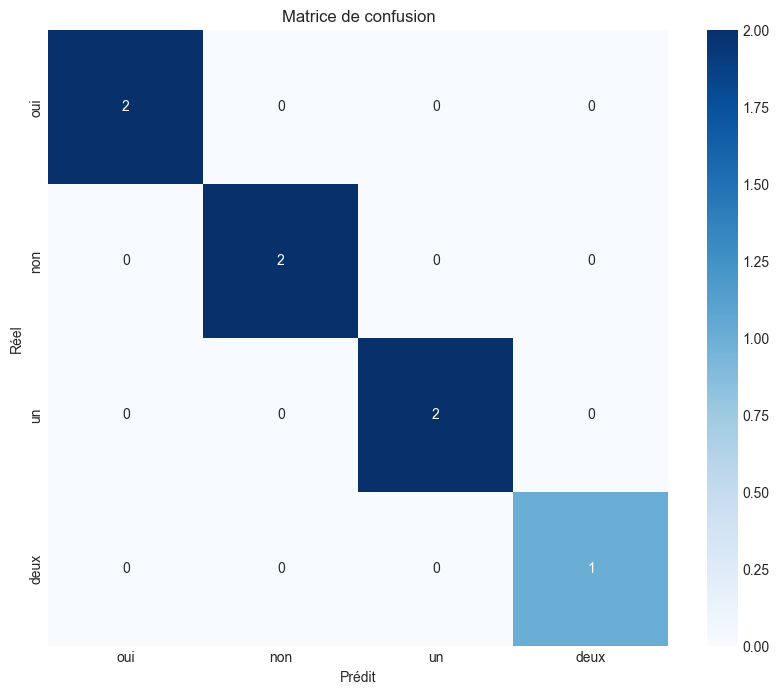

In [7]:
# Prédictions
y_pred = model.predict(X_test_scaled)

# Rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=target_words))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_words, yticklabels=target_words)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

## Sauvegarde du modèle

In [8]:
# Sauvegarder le modèle et le scaler
model_data = {
    'model': model,
    'scaler': scaler,
    'target_words': target_words,
    'n_mfcc': n_mfcc,
    'fs': fs
}

model_path = os.path.join(models_dir, 'speech_recognition_model.pkl')

with open(model_path, 'wb') as f:
    pickle.dump(model_data, f)

print(f"Modèle sauvegardé dans {model_path}")

Modèle sauvegardé dans ../models\speech_recognition_model.pkl


## Fonction de test en temps réel

In [9]:
def record_and_predict(duration=1, fs=fs):
    """
    Enregistre un mot prononcé et prédit sa classe.
    """
    print("Enregistrement en cours...")
    
    # Countdown
    for i in range(3, 0, -1):
        print(f"{i}...")
        sd.sleep(int(500))
        
    print("Parlez maintenant !")
    
    # Enregistrement
    audio = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float32')
    sd.wait()
    
    # Normalisation
    if np.max(np.abs(audio)) > 0:
        audio = audio / np.max(np.abs(audio))
    
    # Conversion en mono si nécessaire
    if audio.ndim > 1:
        audio = audio.mean(axis=1)
    
    # Lecture de l'audio
    display(ipd.Audio(audio.flatten(), rate=fs))
    
    # Extraction des caractéristiques
    mfccs = librosa.feature.mfcc(y=audio.flatten(), sr=fs, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)
    
    # Normalisation
    mfccs_scaled = scaler.transform([mfccs_mean])
    
    # Prédiction
    prediction = model.predict(mfccs_scaled)
    probabilities = model.predict_proba(mfccs_scaled)
    
    # Afficher le résultat
    predicted_word = target_words[prediction[0]]
    print(f"\nMot prédit : {predicted_word}")
    
    # Afficher les probabilités
    print("\nProbabilités :")
    for i, word in enumerate(target_words):
        print(f"  {word}: {probabilities[0][i]:.4f}")
    
    return predicted_word, probabilities[0]

# Fonction pour tester le modèle sur plusieurs enregistrements
def test_model_interactively(num_tests=5):
    """
    Teste le modèle sur plusieurs enregistrements effectués par l'utilisateur.
    """
    results = []
    
    for i in range(num_tests):
        print(f"\n=== Test {i+1}/{num_tests} ===")
        word = input("Quel mot allez-vous dire ? (oui/non/un/deux) : ")
        
        predicted_word, _ = record_and_predict()
        
        results.append({
            'actual': word,
            'predicted': predicted_word,
            'correct': word == predicted_word
        })
    
    # Afficher les résultats
    correct = sum(r['correct'] for r in results)
    print(f"\n=== Résultats ===")
    print(f"Précision : {correct}/{len(results)} ({correct/len(results):.0%})")
    
    return results

## Test interactif

In [18]:
#record_and_predict()
test_model_interactively(num_tests=4)



=== Test 1/4 ===


Quel mot allez-vous dire ? (oui/non/un/deux) :  un


Enregistrement en cours...
3...
2...
1...
Parlez maintenant !



Mot prédit : un

Probabilités :
  oui: 0.0210
  non: 0.0109
  un: 0.9166
  deux: 0.0515

=== Test 2/4 ===


Quel mot allez-vous dire ? (oui/non/un/deux) :  deux 


Enregistrement en cours...
3...
2...
1...
Parlez maintenant !



Mot prédit : deux

Probabilités :
  oui: 0.3813
  non: 0.0035
  un: 0.0074
  deux: 0.6078

=== Test 3/4 ===


Quel mot allez-vous dire ? (oui/non/un/deux) :  oui


Enregistrement en cours...
3...
2...
1...
Parlez maintenant !



Mot prédit : oui

Probabilités :
  oui: 0.8965
  non: 0.0415
  un: 0.0161
  deux: 0.0459

=== Test 4/4 ===


Quel mot allez-vous dire ? (oui/non/un/deux) :  non


Enregistrement en cours...
3...
2...
1...
Parlez maintenant !



Mot prédit : non

Probabilités :
  oui: 0.0447
  non: 0.8790
  un: 0.0494
  deux: 0.0269

=== Résultats ===
Précision : 3/4 (75%)


[{'actual': 'un', 'predicted': 'un', 'correct': True},
 {'actual': 'deux ', 'predicted': 'deux', 'correct': False},
 {'actual': 'oui', 'predicted': 'oui', 'correct': True},
 {'actual': 'non', 'predicted': 'non', 'correct': True}]

# PArtie 2

In [15]:
def visualize_pipeline(duration=1, fs=fs):
    """
    Visualise le pipeline complet : audio → MFCC → réseau de neurones → prédiction
    """
    plt.figure(figsize=(20, 12))
    
    # 1. Enregistrement audio
    print("Enregistrement en cours...")
    for i in range(3, 0, -1):
        print(f"{i}...")
        sd.sleep(int(500))
    print("Parlez maintenant !")
    
    audio = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float32')
    sd.wait()
    
    if np.max(np.abs(audio)) > 0:
        audio = audio / np.max(np.abs(audio))
    audio = audio.flatten()
    
    # 2. Visualisation de la forme d'onde
    plt.subplot(4, 1, 1)
    time = np.arange(0, len(audio)) / fs
    plt.plot(time, audio)
    plt.title('1. Forme d\'onde audio (entrée)', fontsize=14)
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # 3. Visualisation du spectrogramme
    plt.subplot(4, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=fs, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('2. Spectrogramme (représentation temps-fréquence)', fontsize=14)
    
    # 4. Extraction et visualisation des MFCC
    mfccs = librosa.feature.mfcc(y=audio, sr=fs, n_mfcc=n_mfcc)
    
    plt.subplot(4, 1, 3)
    librosa.display.specshow(mfccs, sr=fs, x_axis='time')
    plt.colorbar()
    plt.title('3. Coefficients MFCC (caractéristiques)', fontsize=14)
    
    # Calculer la moyenne des MFCC (notre vecteur d'entrée pour le modèle)
    mfccs_mean = np.mean(mfccs, axis=1)
    
    # 5. Normaliser avec le scaler
    mfccs_scaled = scaler.transform([mfccs_mean])
    
    # 6. Obtenir les probabilités pour chaque classe
    probabilities = model.predict_proba(mfccs_scaled)[0]
    predicted_class = np.argmax(probabilities)
    
    # 7. Visualiser les probabilités
    plt.subplot(4, 1, 4)
    bars = plt.bar(np.arange(len(target_words)), probabilities, color='skyblue')
    bars[predicted_class].set_color('navy')
    plt.xticks(np.arange(len(target_words)), target_words)
    plt.title('4. Prédiction du réseau de neurones (sortie)', fontsize=14)
    plt.xlabel('Classe (mot)')
    plt.ylabel('Probabilité')
    plt.ylim(0, 1)
    
    for i, prob in enumerate(probabilities):
        plt.text(i, prob + 0.05, f'{prob:.2f}', ha='center')
    
    plt.tight_layout(pad=3.0)
    plt.show()
    
    # Afficher le résultat
    predicted_word = target_words[predicted_class]
    print(f"\nMot prédit : {predicted_word} (probabilité: {probabilities[predicted_class]:.2f})")
    
    # Lecture audio
    display(ipd.Audio(audio, rate=fs))
    
    # Bonus : Visualisation schématique de l'architecture du réseau
    plt.figure(figsize=(14, 6))
    
    # Paramètres pour le dessin
    input_layer_size = n_mfcc
    hidden_layer_size = model.hidden_layer_sizes[0]
    output_layer_size = len(target_words)
    
    # Coordonnées des couches
    layer_positions = [0.1, 0.5, 0.9]  # x positions for input, hidden, output layers
    
    # Dessiner les neurones
    # Couche d'entrée
    for i in range(input_layer_size):
        y_pos = (i+1) / (input_layer_size+1)
        circle = plt.Circle((layer_positions[0], y_pos), 0.02, color='skyblue', ec='navy')
        plt.gca().add_patch(circle)
        if i == 0 or i == input_layer_size-1 or i == input_layer_size//2:
            plt.text(layer_positions[0]-0.07, y_pos, f'MFCC {i+1}', ha='right', va='center')
    
    # Couche cachée (afficher seulement quelques neurones représentatifs)
    visible_neurons = min(10, hidden_layer_size)
    for i in range(visible_neurons):
        y_pos = (i+1) / (visible_neurons+1)
        circle = plt.Circle((layer_positions[1], y_pos), 0.02, color='lightgreen', ec='darkgreen')
        plt.gca().add_patch(circle)
    
    # Indiquer s'il y a plus de neurones non affichés
    if hidden_layer_size > visible_neurons:
        plt.text(layer_positions[1], 0.5, f'(+ {hidden_layer_size-visible_neurons} autres)', 
                 ha='center', va='bottom')
    
    # Couche de sortie
    for i in range(output_layer_size):
        y_pos = (i+1) / (output_layer_size+1)
        color = 'navy' if i == predicted_class else 'salmon'
        circle = plt.Circle((layer_positions[2], y_pos), 0.02, color=color, ec='darkred')
        plt.gca().add_patch(circle)
        plt.text(layer_positions[2]+0.07, y_pos, f'{target_words[i]}: {probabilities[i]:.2f}', 
                 ha='left', va='center', weight='bold' if i == predicted_class else 'normal')
    
    # Dessiner quelques connexions (juste pour l'illustration)
    # Nous dessinons un sous-ensemble aléatoire pour éviter de surcharger l'image
    np.random.seed(42)  # Pour la reproductibilité
    
    # De l'entrée vers la couche cachée
    for i in range(min(5, input_layer_size)):
        y1 = (i+1) / (input_layer_size+1)
        for j in range(min(3, visible_neurons)):
            if np.random.random() < 0.3:  # Dessiner seulement 30% des connexions
                y2 = (j+1) / (visible_neurons+1)
                plt.plot([layer_positions[0], layer_positions[1]], [y1, y2], 'gray', alpha=0.3)
    
    # De la couche cachée vers la sortie
    for i in range(min(7, visible_neurons)):
        y1 = (i+1) / (visible_neurons+1)
        for j in range(output_layer_size):
            if np.random.random() < 0.4:  # Dessiner seulement 40% des connexions
                y2 = (j+1) / (output_layer_size+1)
                plt.plot([layer_positions[1], layer_positions[2]], [y1, y2], 'gray', alpha=0.3)
    
    # Étiquettes des couches
    plt.text(layer_positions[0], 0.02, 'Couche d\'entrée\n(13 MFCC)', ha='center', va='bottom', weight='bold')
    plt.text(layer_positions[1], 0.02, f'Couche cachée\n({hidden_layer_size} neurones)', ha='center', va='bottom', weight='bold')
    plt.text(layer_positions[2], 0.02, 'Couche de sortie\n(4 classes)', ha='center', va='bottom', weight='bold')
    
    # Configurer les axes
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title('Architecture du réseau de neurones (MLP)', fontsize=16)
    
    plt.tight_layout()
    plt.show()
    
    return predicted_word



Enregistrement en cours...
3...
2...
1...
Parlez maintenant !


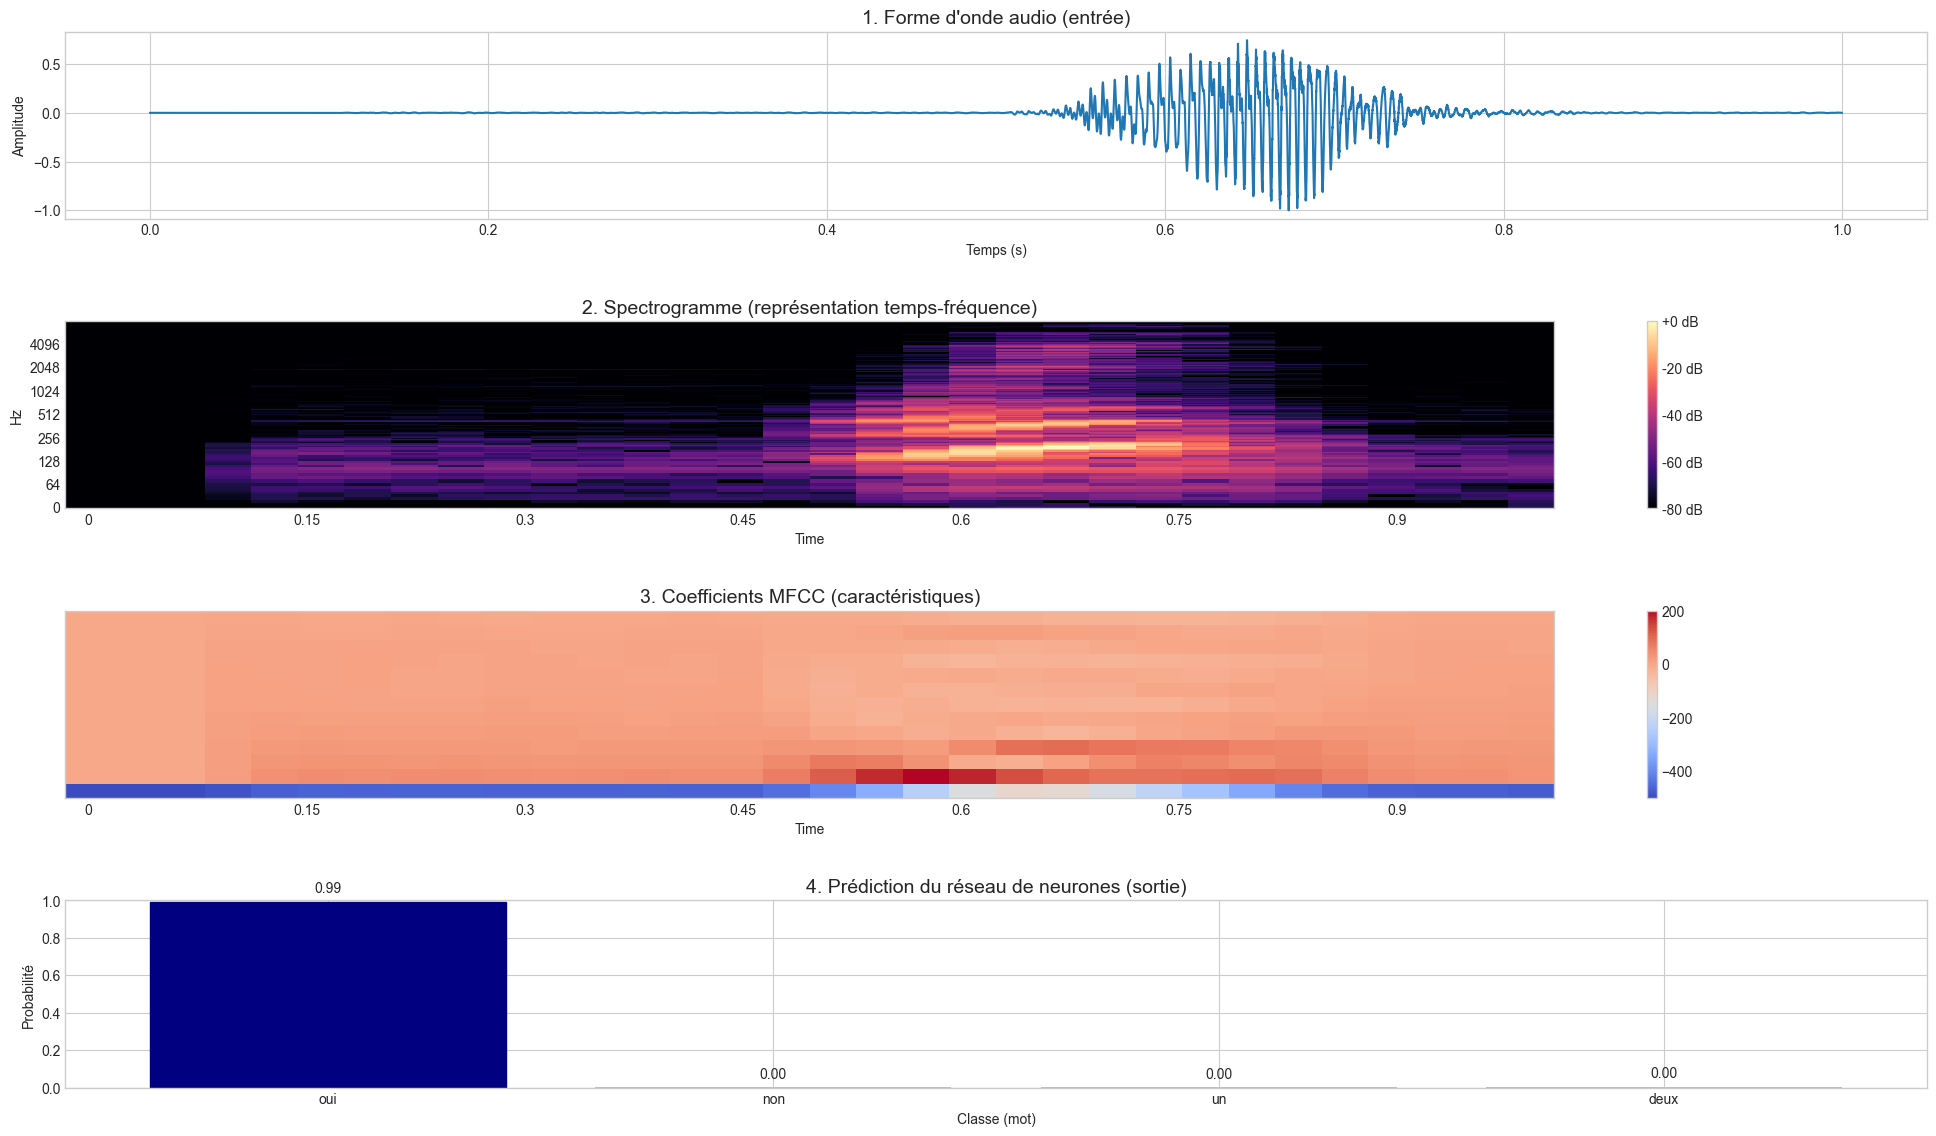


Mot prédit : oui (probabilité: 0.99)


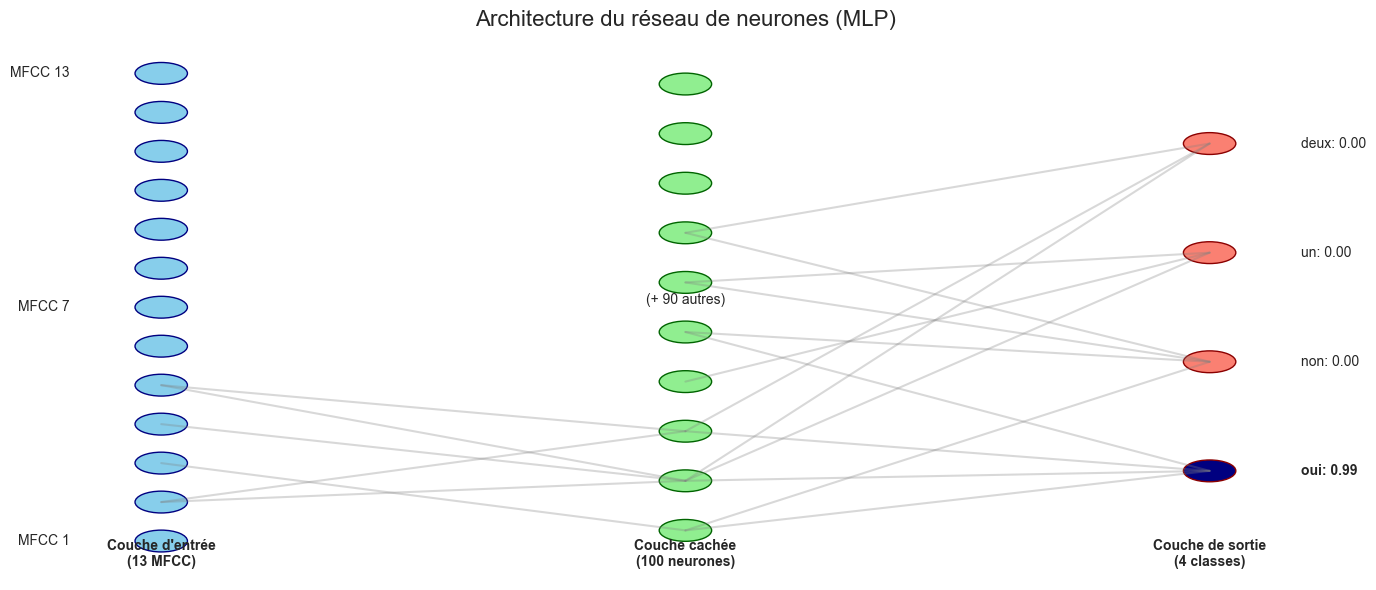

'oui'

In [17]:
# Exécuter la visualisation
visualize_pipeline()
